# A TUTORIAL ON EM FOR BAYESIAN LINEAR REGRESSION

by Sebastian T. Glavind, April, 2020

In [132]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import pymc3
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

# Example 1: Slope only

See Bishop(2006; Sec. 9.3.4) and Theodoridis (2020; Sec. 12.5).

In the simplest case, sometimes called ordinary linear regression, the observation errors are
independent and have equal variance;

$$ y | w, \sigma, x \sim \mathcal{N}(w x,\sigma^2), $$

thus we consider a single input with $w_0 = 0$.

In this example, we will consider the probabilistic modeling of weight parameter only and take $\sigma$ to be a fixed parameter, which will be fitted. We adapt a Gaussian prior for the weight parameter:
$$ p(w) = \mathcal{N}( 0, \sigma_{w}^{2} ) $$

For notational convenience, we consider the precision instead of the noise variance, thus

$$ \alpha = \frac{1}{\sigma_{w}^2} \quad \text{and} \quad \beta = \frac{1}{\sigma^2}. $$

***
Bishop, Christopher M. Pattern recognition and machine learning. springer, 2006.

Theodoridis, Sergios. Machine learning: a Bayesian and optimization perspective. Academic Press, 2020.
***

## Sample data

### True model parameters

In [133]:
w0_true = 0
w1_true = 8
sigma_true = 2

### Generate data

In [134]:
def generate_training_data(x, w0, w1, sigma):
    n = len(x)
    error = np.random.normal(loc=0, scale=sigma, size=n)
    return( w0 + w1*x + error )

In [135]:
x_tr = np.arange(start=-1, stop=1, step=0.1)
nX_tr = len(x_tr)

In [136]:
np.random.seed(10)
y_tr = generate_training_data(x=x_tr, w0 = w0_true, w1 = w1_true, sigma = sigma_true)

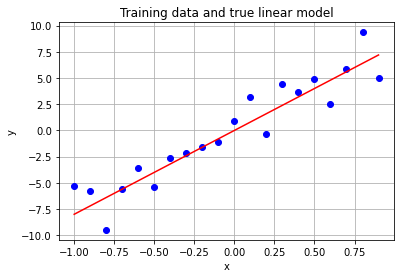

In [137]:
plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training data and true linear model')
plt.grid()

## EM algorithm

In [138]:
XX = (x_tr) # design vector (convention Bishop(2006))
nX = len(XX)
mX = 1

### Initialize algorithm

In [139]:
# Initial parameters
alpha0 = 1
beta0 = 0.1
n_it_max = 1000 # miximum no. of iterations

### EM iterator

In [140]:
for i in range(n_it_max):
    
    if i > 0:
        alpha0 = alpha1
        beta0 = beta1
        
    # E-step:
    Sig_w_pos = ( alpha0 + beta0 * XX.T.dot(XX) )**(-1)
    mu_w_pos = beta0 * (Sig_w_pos * XX.T).dot(y_tr)

    # M-step:
    errors = y_tr - XX * mu_w_pos
    alpha1 = mX / ( mu_w_pos * mu_w_pos + Sig_w_pos )
    beta1 = nX / ( errors.T.dot(errors) + (XX * Sig_w_pos).dot(XX.T) )
    
    # access convergence
    if ( abs( alpha1 - alpha0 ) < 1e-4 * alpha0 )&( abs( beta1 - beta0 ) < 1e-4 * beta0 ):
        break

In [141]:
mu_w_pos, alpha1, np.sqrt(1/beta1), i

(7.736935531099955, 0.01658312374162845, 1.7273844119370416, 5)

# Example 2: Slope and intercept using automatic relevance determination (ARD) prior

See Murphy(2012; Sec.13.7).

Again, we consider the case of ordinary linear regression, but this time including an intercept term;

$$ y | w, \sigma, x \sim \mathcal{N}(w_0 + w_1 x,\sigma^2). $$

In this example, we will consider the probabilistic modeling of the weight parameters only and take $\sigma$ to be a fixed parameter, which will be fitted. For notational convenience, we will consider the precisions instead of the noise variances, thus

$$ \boldsymbol\alpha = \frac{1}{\boldsymbol\sigma_{w}^2} \quad \text{and} \quad \beta = \frac{1}{\sigma^2}, $$

where $\boldsymbol\alpha$ denote the vector of weight precisions and $\beta$ is the noise precision.

In particular, the we will assume the following (full) probabilistic model:

$$ y | \mathbf{w}, \sigma, x \sim \mathcal{N}(\mathbf{w}^T \mathbf{x},1/\beta) $$

$$ \mathbf{w}|\mathbf{A} \sim \mathcal{N}(\boldsymbol0, \mathbf{A}^{-1}), $$

where the input space have been augmented with an additional first argument, which is always 1, in order to write the likelihood in vector notation and $\mathbf{A}=\text{diag}(\boldsymbol\alpha)$.

## Sample data

In [143]:
w0_true = 4
w1_true = 8
sigma_true = 2

In [144]:
def generate_training_data(x, w0, w1, sigma):
    n = len(x)
    error = np.random.normal(loc=0, scale=sigma, size=n)
    return( w0 + w1*x + error )

In [145]:
x_tr = np.arange(start=-1, stop=1, step=0.1)
np.random.seed(10) # good seed
y_tr = generate_training_data(x=x_tr, w0 = w0_true, w1 = w1_true, sigma = sigma_true)

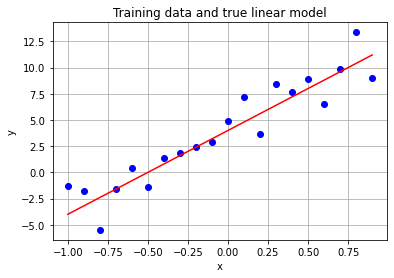

In [146]:
plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training data and true linear model')
plt.grid()

In [147]:
XX = np.vstack((np.ones(len(x_tr)), x_tr)).T # design matrix (convention Bishop(2006))
nX_tr, mX_tr = XX.shape # - np.array([0, 1]); # data dimensions are defined as actual features ;)

In [148]:
x_te = np.arange(start=-1.25, stop=1.25, step=0.1)
XX_te = np.vstack((np.ones(len(x_te)), x_te)).T # design matrix (convention Bishop(2006))
nX_te, mX_te = XX_te.shape # - np.array([0, 1]); # data dimensions are defined as actual features ;)

## EM algorithm

See Murphy(2012; Sec.13.7).

For the case of automatic relevance determination, i.e. $\boldsymbol\alpha$-vector, considered above, we now assume that the distribution for the hyperparameters are sharply peaked, and approximate the posterior with a fixed-point estimate.

### Initialize algorithm

In [149]:
A0_em = np.eye(mX_tr) * 1 # alpha's on the diagonal
beta0_em = 0.1
n_it_max = 1000 # miximum no. of iterations

### EM iterator

In [150]:
for i in range(1000):
    
    if i > 0:
        A0_em = A1_em
        beta0_em = beta1_em
        
    # E-step:
    Sig_w_pos = np.linalg.inv( beta0_em * XX.T.dot(XX) + A0_em )
    mu_w_pos = beta0_em * Sig_w_pos.dot(XX.T).dot(y_tr)

    # M-step:
    errors = y_tr - XX.dot(mu_w_pos)
    A1_em = np.diag( 1 / ( mu_w_pos**2 + np.diag(Sig_w_pos)**2 ) )
    beta1_em = nX_tr / ( errors.T.dot(errors) + np.sum(1 - np.diag(A1_em)*np.diag(Sig_w_pos) )/beta0_em )
    
#     # access convergence - could easily define a stopping criteria here!
#     if ( abs( alpha1 - alpha0 ) < 1e-4 * alpha0 )&( abs( beta1 - beta0 ) < 1e-4 * beta0 ):
#         break

In [151]:
mu_w_pos, Sig_w_pos, A1_em, np.sqrt(1/beta1_em), i

(array([4.1887292 , 7.76300487]),
 array([[0.15439115, 0.02286894],
        [0.02286894, 0.4614036 ]]),
 array([[0.0569175 , 0.        ],
        [0.        , 0.01653517]]),
 1.7584442628014527,
 999)